Install required libraries

In [1]:
!pip install -U torchdata
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm
!pip install 'portalocker>=2.0.0'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 37.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 47.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# Imports

In [2]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from timeit import default_timer as timer
from torch.nn import Transformer
from torch import Tensor
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np
import math
import os
import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

In [3]:
# Set seed.
seed = 42
np.random.seed(seed)

# Data preprocessing

Create source and target language tokenizer. \

In [4]:
SRC_LANGUAGE = 'en'
TGT_LANGUAGE = 'fr'

# Place-holders
token_transform = {}
vocab_transform = {}

token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='fr_core_news_sm')

Load the dataset into a pandas dataframe

In [31]:
df = pd.read_csv('English_French_Pairs.tsv', sep='\t')
df.head()

,1276,Let's try something.,3091,Essayons quelque chose !
0,1276,Let's try something.,456963,Tentons quelque chose !
1,1277,I have to go to sleep.,373908,Je dois aller dormir.
2,1280,Today is June 18th and it is Muiriel's birthday!,3095,Aujourd'hui nous sommes le 18 juin et c'est l'...
3,1280,Today is June 18th and it is Muiriel's birthday!,696081,"Aujourd'hui c'est le 18 juin, et c'est l'anniv..."
4,1282,Muiriel is 20 now.,3097,Muiriel a 20 ans maintenant.



- Remove irrelevant columns
- Rename the header

In [6]:
df_drop = df.drop(df.columns[[0, 2]], axis=1)
df_drop.columns = ["EN", "FR"]
df_drop.head()

,EN,FR
0,Let's try something.,Tentons quelque chose !
1,I have to go to sleep.,Je dois aller dormir.
2,Today is June 18th and it is Muiriel's birthday!,Aujourd'hui nous sommes le 18 juin et c'est l'...
3,Today is June 18th and it is Muiriel's birthday!,"Aujourd'hui c'est le 18 juin, et c'est l'anniv..."
4,Muiriel is 20 now.,Muiriel a 20 ans maintenant.


Randomly take 40,000 data points for POC only and faster training

In [7]:
df_drop = df_drop.sample(n=40000, random_state=1)

Split the data into train and validation sets

In [8]:
train_csv, val_csv = train_test_split(df_drop, test_size=0.2)

Define a custom TranslationDataset class that will be compatible with Pytorch's DataLoader.

In [9]:
# Custom Dataset class.
class TranslationDataset(Dataset):
    def __init__(self, csv):
        self.csv = csv

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        return(
            self.csv['EN'].iloc[idx],
            self.csv['FR'].iloc[idx]
        )

Instantiate training and validation datasets. Print one pair of sample from the training dataset.

In [10]:
train_dataset = TranslationDataset(train_csv)
valid_dataset = TranslationDataset(val_csv)

iterator = iter(train_dataset)
print(next(iterator))

('Goodbye, then.', 'Au revoir, alors.')


- Define a helper function that produces tokens during training.

- Define indices for unkown tokens (UNK_IDX), padding tokens (PAD_IDX), beginning-of-sentences tokens (BOS_IDX), and end-of-sentence tokens (EOS_IDX)

- For both English and French, create a vocabulary that maps each unique token to a unique integer.

- Setting default index for Unkown tokens

In [11]:
# Helper function to yield list of tokens.
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}
    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices.
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Create torchtext's Vocab object.
    vocab_transform[ln] = build_vocab_from_iterator(
        yield_tokens(train_dataset, ln),
        min_freq=1,
        specials=special_symbols,
        special_first=True,
    )

# Set ``UNK_IDX`` as the default index. This index is returned when the token is not found.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

Create helper functions for transforms, tokenization, and numericalizations of sentences.

- sequential_transforms() makes it easier to execute a series of transformations on the input text in a streamlit manner.

- tensor_transform() adds the BOS_IDX and EOS_IDX indices at the beginning and at the end of a list of token IDS. It then converts the entire sequence into a Pytorch tensor.

- collate_fn() defines hoe to collate individual data points into batches. It tokenized the input sentences, pads them to the maxim length within the batch, and returns source and target batches.

In [12]:
# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))
# `src` and `tgt` language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], # Tokenization
                                               vocab_transform[ln], # Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor
# function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=True)
    return src_batch, tgt_batch

### Model and training hyperparameters

- The SRC and TGT vocabulary size are the sizes of the English and French vocabularies.

- The EMB_SIZE is the size of the vector space in which words will be embedded.

- NHEAD represents the number of heads in the multi-head attention mechanism, which allows the model to focus on different parts of the input simultaneously.

- FFN_HID_DIM for Feed-Forward Network Dimension is the internal hidden dimension of the feed-forward networks present in the transformer.

- BATCH_SIZE determines how many examples the model looks at before making a weight update.

- Encoder and Decoder Layers specify the depth of the transformer. More layers can capture more complex relationships but lead to longer training times and risk of overfitting.

- DEVICE indicates whether calculations will be done on CPU or GPU.

- NUM_EPOCHS determines how many times the model will see the entire dataset.

In [13]:
SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 192
NHEAD = 6
FFN_HID_DIM = 192
BATCH_SIZE = 192
NUM_ENCODER_LAYERS = 2 # As advised
NUM_DECODER_LAYERS = 2 # As advised
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_EPOCHS = 50 # 50

In [14]:
DEVICE

device(type='cuda')

Add function to generate masks for the source and target sentences. Creating masks is needed to prevent the attention mechanism from sharing information regarding the token at the next position, when giving a preductions using all the previous tokens.

In [15]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt):
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]
    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)
    src_padding_mask = (src == PAD_IDX)
    tgt_padding_mask = (tgt == PAD_IDX)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

Positional encoding injects information about the relative/absolute position of tokens in the sequence using sinusoidal functions. Transformers do not have a buit-in notion of sequence order.

In [16]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

Define a layer to transform tokens into embeddings.

In [17]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Model creation and training

In [18]:
class Seq2SeqTransformer(nn.Module):
    def __init__(
        self,
        num_encoder_layers: int,
        num_decoder_layers: int,
        emb_size: int,
        nhead: int,
        src_vocab_size: int,
        tgt_vocab_size: int,
        dim_feedforward: int = 512,
        dropout: float = 0.1
    ):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(
            d_model=emb_size,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
            src: Tensor,
            trg: Tensor,
            src_mask: Tensor,
            tgt_mask: Tensor,
            src_padding_mask: Tensor,
            tgt_padding_mask: Tensor,
            memory_key_padding_mask: Tensor):
              src_emb = self.positional_encoding(self.src_tok_emb(src))
              tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
              outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                            src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
              return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)


Initialize the model

In [19]:
model = Seq2SeqTransformer(
    NUM_ENCODER_LAYERS,
    NUM_DECODER_LAYERS,
    EMB_SIZE,
    NHEAD,
    SRC_VOCAB_SIZE,
    TGT_VOCAB_SIZE,
    FFN_HID_DIM
).to(DEVICE)

Define the loss function and the optimizer

In [20]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

Define data loaders and the entirety of the training and validation functions.

In [21]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
def train_epoch(model, optimizer):
    print('Training')
    model.train()
    losses = 0
    for src, tgt in tqdm(train_dataloader, total=len(list(train_dataloader))):
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:, :-1]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        logits = model(
            src,
            tgt_input,
            src_mask,
            tgt_mask,
            src_padding_mask,
            tgt_padding_mask,
            src_padding_mask
        )
        optimizer.zero_grad()

        tgt_out = tgt[:, 1:]
        loss = loss_fn(logits.view(-1, TGT_VOCAB_SIZE), tgt_out.contiguous().view(-1))
        loss.backward()
        optimizer.step()
        losses += loss.item()
    return losses / len(list(train_dataloader))
val_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
def evaluate(model):
    print('Validating')
    model.eval()
    losses = 0
    for src, tgt in tqdm(val_dataloader, total=len(list(val_dataloader))):
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:, :-1]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(
            src,
            tgt_input,
            src_mask,
            tgt_mask,
            src_padding_mask,
            tgt_padding_mask,
            src_padding_mask
        )
        tgt_out = tgt[:, 1:]
        loss = loss_fn(logits.view(-1, TGT_VOCAB_SIZE), tgt_out.contiguous().view(-1))
        losses += loss.item()
    return losses / len(list(val_dataloader))


Training

In [32]:
train_loss_list, valid_loss_list = [], []
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(model, optimizer)
    valid_loss = evaluate(model)
    end_time = timer()
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {valid_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s \n"))

Training


  0%|          | 0/167 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 1, Train loss: 2.238, Val loss: 3.042, Epoch time = 42.402s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 2, Train loss: 2.241, Val loss: 3.042, Epoch time = 40.629s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 3, Train loss: 2.240, Val loss: 3.042, Epoch time = 40.401s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 4, Train loss: 2.241, Val loss: 3.042, Epoch time = 39.164s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 5, Train loss: 2.240, Val loss: 3.042, Epoch time = 39.426s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 6, Train loss: 2.238, Val loss: 3.042, Epoch time = 39.661s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 7, Train loss: 2.239, Val loss: 3.042, Epoch time = 39.950s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 8, Train loss: 2.240, Val loss: 3.042, Epoch time = 38.400s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 9, Train loss: 2.240, Val loss: 3.042, Epoch time = 38.475s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 10, Train loss: 2.238, Val loss: 3.042, Epoch time = 39.270s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 11, Train loss: 2.239, Val loss: 3.042, Epoch time = 38.546s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 12, Train loss: 2.242, Val loss: 3.042, Epoch time = 38.511s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 13, Train loss: 2.240, Val loss: 3.042, Epoch time = 39.122s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 14, Train loss: 2.239, Val loss: 3.042, Epoch time = 40.898s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 15, Train loss: 2.240, Val loss: 3.042, Epoch time = 39.755s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 16, Train loss: 2.239, Val loss: 3.042, Epoch time = 39.664s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 17, Train loss: 2.240, Val loss: 3.042, Epoch time = 40.090s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 18, Train loss: 2.242, Val loss: 3.042, Epoch time = 40.953s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 19, Train loss: 2.240, Val loss: 3.042, Epoch time = 39.433s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 20, Train loss: 2.239, Val loss: 3.042, Epoch time = 39.121s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 21, Train loss: 2.240, Val loss: 3.042, Epoch time = 38.629s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 22, Train loss: 2.241, Val loss: 3.042, Epoch time = 40.230s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 23, Train loss: 2.241, Val loss: 3.042, Epoch time = 38.624s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 24, Train loss: 2.239, Val loss: 3.042, Epoch time = 38.455s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 25, Train loss: 2.241, Val loss: 3.042, Epoch time = 37.764s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 26, Train loss: 2.241, Val loss: 3.042, Epoch time = 40.245s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 27, Train loss: 2.241, Val loss: 3.042, Epoch time = 39.832s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 28, Train loss: 2.242, Val loss: 3.042, Epoch time = 39.516s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 29, Train loss: 2.240, Val loss: 3.042, Epoch time = 39.524s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 30, Train loss: 2.240, Val loss: 3.042, Epoch time = 41.328s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 31, Train loss: 2.240, Val loss: 3.042, Epoch time = 39.908s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 32, Train loss: 2.241, Val loss: 3.042, Epoch time = 39.251s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 33, Train loss: 2.239, Val loss: 3.042, Epoch time = 39.368s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 34, Train loss: 2.240, Val loss: 3.042, Epoch time = 39.840s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 35, Train loss: 2.242, Val loss: 3.042, Epoch time = 39.074s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 36, Train loss: 2.239, Val loss: 3.042, Epoch time = 38.377s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 37, Train loss: 2.238, Val loss: 3.042, Epoch time = 38.063s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 38, Train loss: 2.241, Val loss: 3.042, Epoch time = 39.230s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 39, Train loss: 2.238, Val loss: 3.042, Epoch time = 38.711s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 40, Train loss: 2.238, Val loss: 3.042, Epoch time = 39.144s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 41, Train loss: 2.241, Val loss: 3.042, Epoch time = 39.562s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 42, Train loss: 2.239, Val loss: 3.042, Epoch time = 40.853s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 43, Train loss: 2.241, Val loss: 3.042, Epoch time = 39.834s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 44, Train loss: 2.239, Val loss: 3.042, Epoch time = 38.830s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 45, Train loss: 2.240, Val loss: 3.042, Epoch time = 38.700s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 46, Train loss: 2.239, Val loss: 3.042, Epoch time = 38.495s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 47, Train loss: 2.240, Val loss: 3.042, Epoch time = 38.850s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 48, Train loss: 2.238, Val loss: 3.042, Epoch time = 37.845s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 49, Train loss: 2.240, Val loss: 3.042, Epoch time = 38.884s 

Training


  0%|          | 0/167 [00:00<?, ?it/s]

Validating


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 50, Train loss: 2.240, Val loss: 3.042, Epoch time = 39.579s 



Save the model and loss plots

In [33]:
os.makedirs('outputs', exist_ok=True)

In [34]:
def save_plots(train_loss, valid_loss):
    """
    Function to save the loss plots to disk.
    """
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='blue', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-',
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join('outputs', 'loss.png'))
    plt.show()

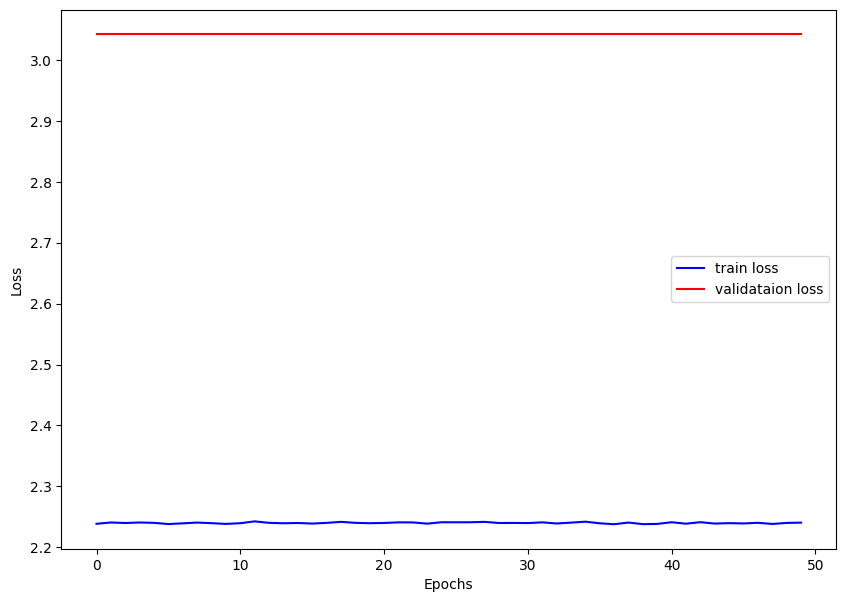

In [35]:
save_plots(train_loss_list, valid_loss_list)

Save the model

In [36]:
torch.save(model, 'outputs/model.pth')

# Evaluation

Inference

In [37]:
model = torch.load('outputs/model.pth')

In [38]:
# Helper function to generate output sequence using greedy algorithm.
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        if i == 0:
            ys = ys.transpose(1, 0)
        tgt_mask = (generate_square_subsequent_mask(ys.size(1))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        if next_word == EOS_IDX:
            break
    return ys

# Translation function.
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(1, -1)
    num_tokens = src.shape[1]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [39]:
# SRC, GT pairs from the validation set.
infer_sentences = [
    ["Take a seat.", "Prends place !"],
    ["I'm not scared to die", "Je ne crains pas de mourir."],
    ["You'd better make sure that it is true.", "Tu ferais bien de t'assurer que c'est vrai."],
    ["The clock has stopped.", "L'horloge s'est arrêtée."],
    ["Take any two cards you like.", "Prends deux cartes de ton choix."]
]

# Print translations
for sentence in infer_sentences:
    print(f"SRC: {sentence[0]}")
    print(f"GT: {sentence[1]}")
    print(f"PRED: {translate(model, sentence[0])}\n")

SRC: Take a seat.
GT: Prends place !
PRED:  Prends un coup . 

SRC: I'm not scared to die
GT: Je ne crains pas de mourir.
PRED:  Je ne suis pas mourir à mourir . 

SRC: You'd better make sure that it is true.
GT: Tu ferais bien de t'assurer que c'est vrai.
PRED:  Tu ferais mieux que ça va être vrai vrai . 

SRC: The clock has stopped.
GT: L'horloge s'est arrêtée.
PRED:  Le bébé a des défauts . 

SRC: Take any two cards you like.
GT: Prends deux cartes de ton choix.
PRED:  Prenez deux jours . 



In [47]:
from nltk.translate.bleu_score import corpus_bleu

# Initialize list to store BLEU scores
bleu_scores = []

# Calculate BLEU score for each sentence
for sentence in infer_sentences:
    # Reference translations
    references = [[sentence[1].split()]]

    # Predicted translations
    predictions = [translate(model, sentence[0]).split()]

    # Calculate BLEU score for each prediction and append to list
    bleu_scores.append(corpus_bleu(references, predictions))

# Print BLEU score for each prediction
for i, bleu_score in enumerate(bleu_scores):
    print(f"BLEU score for prediction {i}: {bleu_score}")

BLEU score for prediction 0: 1.2882297539194154e-231
BLEU score for prediction 1: 7.176381577237209e-155
BLEU score for prediction 2: 6.373704167435469e-155
BLEU score for prediction 3: 0
BLEU score for prediction 4: 7.813508425061864e-232


The above BLEU scores are extremelly low